In [1]:
#force install opencv v3.4 to use the SIFT functions

! yes | pip3 uninstall opencv-python
! yes | pip3 uninstall opencv-contrib-python
! yes | pip3 install opencv-python==3.4.2.16
! yes | pip3 install opencv-contrib-python==3.4.2.16

Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/cv2/*
    /usr/local/lib/python3.6/dist-packages/opencv_python-4.1.2.30.dist-info/*
Proceed (y/n)?   Successfully uninstalled opencv-python-4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/opencv_contrib_python-4.1.2.30.dist-info/*
Proceed (y/n)?   Successfully uninstalled opencv-contrib-python-4.1.2.30
     |████████████████████████████████| 25.0MB 130kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6MB 103kB/s 


In [0]:
import os
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn import metrics, svm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import cv2 
from PIL import Image
from skimage import color

In [16]:
print ('OpenCV Version (should be 3.1.0, with nonfree packages installed, for this tutorial):')
print (cv2.__version__) 

OpenCV Version (should be 3.1.0, with nonfree packages installed, for this tutorial):
3.4.2


In [0]:
binary_flder = '/content/drive/Shared drives/DS8013/Data/Binary/'

In [0]:
X = np.load(binary_flder + 'X.npy')
y = np.load(binary_flder  + 'y.npy')

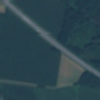

In [24]:
Image.fromarray(X[1]).resize((100,100))

In [0]:
unique_elements, counts_elements = np.unique(y, return_counts=True)

In [26]:
(list(zip(unique_elements, counts_elements)))

[('AnnualCrop', 3000),
 ('Forest', 3000),
 ('HerbaceousVegetation', 3000),
 ('Highway', 2500),
 ('Industrial', 2500),
 ('Pasture', 2000),
 ('PermanentCrop', 2500),
 ('Residential', 3000),
 ('River', 2500),
 ('SeaLake', 3000)]

One-encoder for Y

In [0]:
# one hot encode

#label encoding to integer
le = preprocessing.LabelEncoder()
le.fit(y)

#after encoding
label_encoded = le.transform(y)

# one hot encode
y_onehot = to_categorical(label_encoded)

Covert to Graysacle

In [0]:
X_gray =np.array([cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in X ])

Resize

In [0]:
X_resize = [cv2.resize(img, (256, 256)) for img in X]

Generate Sift on grayscale image

In [0]:
sift = cv2.xfeatures2d.SIFT_create()
X_sift = [ sift.detectAndCompute(x, None) for x in X_gray]

Visualize Sift features

Highway


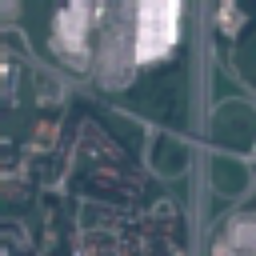

In [13]:
i = 101
print(y[i])
Image.fromarray(X_resize[i]) #enlarged to visualize

Highway


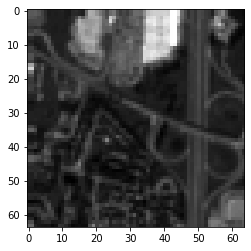

In [14]:

print(y[i])
plt.imshow(X_gray[i], cmap='gray')

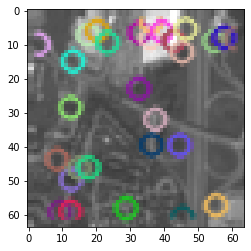

In [15]:
x = X_gray[i]
plt.imshow(cv2.drawKeypoints(x, X_sift[i][0], x))

# Split data




In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_resize, y, test_size=0.33, random_state=42, shuffle=True)

In [31]:
len(X_train)

18090

In [32]:
len(X_test)

8910

In [33]:
y_train[0:10]

array(['PermanentCrop', 'HerbaceousVegetation', 'SeaLake', 'Highway',
       'Pasture', 'SeaLake', 'HerbaceousVegetation', 'Residential',
       'River', 'SeaLake'], dtype='<U20')

# Visual Bag of Words

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn import svm
import pandas as pd
import pickle
import numpy as np
import random
import sklearn
import scipy.cluster.vq as vq

In [0]:
run_all_process = False

In [0]:
VOC_SIZE = 200              # the number of cluster center point
NUMBER_IMAGES_CLASS = 10      # the number of images per class
SIFT_type = 'sparse'           # The type of SIFT feature  : dense or sparse

# C_range = 10.0 ** np.arange(-2, 4)
# print(dict(C=C_range.tolist()))
PARAM_GRID = dict(C=[1.0,10.0,50.0,70.0,100.0,150.0,200.0,250.0,300.0,500.0])   # Parameter C of SVM (linear kernel)
random.seed(777)

In [0]:
prepare_dataset = False
feature_extraction = True
clustering_and_build_codebook = True
image_representation = True
learning_and_recognition = True

In [0]:
if run_all_process:
    prepare_dataset = True
    feature_extraction = True
    clustering_and_build_codebook = True
    image_representation = True
    learning_and_recognition = True

In [0]:
import torch
import random
import sys

device_gpu = torch.device('cuda')
device_cpu = torch.device('cpu')

In [0]:
# Choosing `num_centers` random data points as the initial centers
def random_init(dataset, num_centers):
    num_points = dataset.size(0)
    dimension = dataset.size(1)
    used = torch.zeros(num_points, dtype=torch.long)
    indices = torch.zeros(num_centers, dtype=torch.long)
    for i in range(num_centers):
        while True:
            cur_id = random.randint(0, num_points - 1)
            if used[cur_id] > 0:
                continue
            used[cur_id] = 1
            indices[i] = cur_id
            break
    indices = indices.to(device_gpu)
    centers = torch.gather(dataset, 0, indices.view(-1, 1).expand(-1, dimension))
    return centers

# Compute for each data point the closest center
def compute_codes(dataset, centers):
    num_points = dataset.size(0)
    dimension = dataset.size(1)
    num_centers = centers.size(0)
    # 5e8 should vary depending on the free memory on the GPU
    # Ideally, automatically ;)
    chunk_size = int(5e8 / num_centers)
    codes = torch.zeros(num_points, dtype=torch.long, device=device_gpu)
    centers_t = torch.transpose(centers, 0, 1)
    centers_norms = torch.sum(centers ** 2, dim=1).view(1, -1)
    for i in range(0, num_points, chunk_size):
        begin = i
        end = min(begin + chunk_size, num_points)
        dataset_piece = dataset[begin:end, :]
        dataset_norms = torch.sum(dataset_piece ** 2, dim=1).view(-1, 1)
        distances = torch.mm(dataset_piece, centers_t)
        distances *= -2.0
        distances += dataset_norms
        distances += centers_norms
        _, min_ind = torch.min(distances, dim=1)
        codes[begin:end] = min_ind
    return codes

# Compute new centers as means of the data points forming the clusters
def update_centers(dataset, codes, num_centers):
    num_points = dataset.size(0)
    dimension = dataset.size(1)
    centers = torch.zeros(num_centers, dimension, dtype=torch.float, device=device_gpu)
    cnt = torch.zeros(num_centers, dtype=torch.float, device=device_gpu)
    centers.scatter_add_(0, codes.view(-1, 1).expand(-1, dimension), dataset)
    cnt.scatter_add_(0, codes, torch.ones(num_points, dtype=torch.float, device=device_gpu))
    # Avoiding division by zero
    # Not necessary if there are no duplicates among the data points
    cnt = torch.where(cnt > 0.5, cnt, torch.ones(num_centers, dtype=torch.float, device=device_gpu))
    centers /= cnt.view(-1, 1)
    return centers

def cluster(dataset, num_centers):
    centers = random_init(dataset, num_centers)
    codes = compute_codes(dataset, centers)
    num_iterations = 0
    while True:
        sys.stdout.write('.')
        sys.stdout.flush()
        num_iterations += 1
        centers = update_centers(dataset, codes, num_centers)
        new_codes = compute_codes(dataset, centers)
        # Waiting until the clustering stops updating altogether
        # This is too strict in practice
        if torch.equal(codes, new_codes):
            sys.stdout.write('\n')
            print('Converged in %d iterations' % num_iterations)
            break
        codes = new_codes
    return centers, codes


In [0]:
def extract_sift_descriptors(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

def extract_DenseSift_descriptors(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    dsift_step_size = 4
    kps = [cv2.KeyPoint(x,y,dsift_step_size)
                for y in range(0, gray.shape[0],dsift_step_size)
                for x in range(0, gray.shape[1],dsift_step_size)]
    kp, des = sift.compute(gray, kps)
    
    return [kp, des]

def build_codebook(X, voc_size):
    """
    Inupt a list of feature descriptors
    voc_size is the "K" in K-means, k is also called vocabulary size
    Return the codebook/dictionary
    """
    features = np.vstack((descriptor for descriptor in X)).astype(np.float32)
    dataset = torch.from_numpy(features).to(torch.device('cuda'))
    print('Starting clustering')
    centers, codes = cluster(dataset, voc_size)
    return centers.cpu()


def input_vector_encoder(feature, codebook):
    """
    Input all the local feature of the image
    Pooling (encoding) by codebook and return
    """
    code, _ = vq.vq(feature, codebook)
    word_hist, bin_edges = np.histogram(code, bins=range(codebook.shape[0] + 1), normed=True)
    return word_hist

def bootstrap_x_y_resample(x,y, n=None):
    if n == None:
        n = len(x)
    if len(x)!=len(y):
        print('the number of data is not match the number of label')
    resample_i = np.floor(np.random.rand(n) * len(x)).astype(int)
    X_resample = np.array(x)[resample_i]
    Y_resample = np.array(y)[resample_i]
    # print('original label mean:', sum(np.array(y).astype(int)) / len(y))
    # print('resampled label mean:', sum(np.array(Y_resample).astype(int)) / len(Y_resample))
    return X_resample,Y_resample

In [0]:
def svm_classifier(x_train, y_train, x_test=None, y_test=None,param_grid={}):
    if x_test is None and y_test is None:
        x_train, x_test, y_train, y_test = train_test_split(
                x_train, y_train, test_size=0.2, random_state=6)
        print("Spliting train:{}/test:{} from training data".format(len(x_train), len(x_test)))

    #### Time to spend too much
#     gamma_range = 10.0 ** np.arange(-4, 4)
#     param_grid = dict(gamma=gamma_range.tolist(), C=C_range.tolist())
    # Grid search for C, gamma, 5-fold CV
    print("Tuning hyper-parameters\n")
#     clf = GridSearchCV(svm.SVC(), param_grid, cv=5, n_jobs=-1)
    clf = GridSearchCV(svm.LinearSVC(), param_grid, cv=5, n_jobs=-1)
   
    clf.fit(x_train, y_train)
    # print("Best parameters set found on development set:\n")
    # print(clf.best_estimator_)
    print("\nGrid scores on development set:\n")
    test_score = clf.cv_results_['mean_test_score']
    test_std = clf.cv_results_['std_test_score']
    params = clf.cv_results_['params']
    for i in range(len(test_score)):
        print("%0.3f (+/-%0.03f) for %r" % (test_score[i], test_std[i] * 2, params[i]))
    print("\nDetailed classification report:\n")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.\n")
    y_true, y_pred = y_test, clf.predict(x_test)
    #print(classification_report(y_true, y_pred, target_names=get_label()))
    print(classification_report(y_true, y_pred))

In [43]:
# Feature(SIFT Descriptors) Extraction

if feature_extraction:
    # Training
    if SIFT_type.lower() =='sparse' or SIFT_type.lower() =='s':
        print('Sparse SIFT feature extraction')
        x_train = [extract_sift_descriptors(img) for img in X_train]
        x_test = [extract_sift_descriptors(img) for img in X_test]
        # Remove None in SIFT extraction
        x_train = [each for each in zip(X_train, y_train) if not each[0] is None]
        x_train, y_train = zip(*x_train)
        x_test = [each for each in zip(X_test, y_test) if not each[0] is None]
        x_test, y_test = zip(*x_test)
    elif SIFT_type.lower() =='dense' or SIFT_type.lower() =='d':
        print("Dense SIFT feature extraction")
        x_train = [extract_DenseSift_descriptors(img) for img in X_train]
        x_test = [extract_DenseSift_descriptors(img) for img in X_test]
        x_train_kp, x_train = zip(*x_train)
        x_test_kp, x_test = zip(*x_test)
        
    with open('./x_train.pkl','wb') as f:
        pickle.dump(x_train, f)
    with open('./x_test.pkl','wb') as f:
        pickle.dump(x_test, f)
    with open('./y_train.pkl', 'wb') as f:
        pickle.dump(y_train, f)
    with open('./y_test.pkl', 'wb') as f:
        pickle.dump(y_test, f)
    
      
        
else: 
    with open('./x_train.pkl','rb') as fp:
        x_train = pickle.load(fp)
    with open('./x_test.pkl','rb')  as fp:
        x_test = pickle.load(fp)
    with open('./y_train.pkl','rb') as fp:
        y_train = pickle.load(fp)
    with open('./y_test.pkl','rb') as fp:
        y_test = pickle.load(fp)
    print("SIFT features ard loaded")

Sparse SIFT feature extraction


In [44]:
# Builing Codebook and Clustering
codebook =None
num_center = None
if clustering_and_build_codebook:
    print("Building the codebook, Wait a minute")
    codebook = build_codebook(x_train, voc_size=VOC_SIZE)
    print('codebook shape : ',codebook.shape)
    num_center = len(codebook)
    with open('./bow_codebook.pkl', 'wb') as f:
        pickle.dump(codebook, f)
else :
    print('Loading the last codebook.')
    with open('./bow_codebook.pkl','rb') as fp:
        codebook = pickle.load(fp)
        num_center = len(codebook)

Building the codebook, Wait a minute


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Starting clustering


RuntimeError: ignored

In [0]:
piikljllj kj lkj lkj l     kj lkjl                    k jlkj lkjlkj lkjl


In [0]:
;lk;k;k      